In [62]:
# Import required packages\n",
import os
import numpy as np
import pandas as pd
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
from torch.nn.init import kaiming_uniform
from torchvision.transforms import Resize, ToTensor, Compose
import matplotlib.pyplot as plt
import cv2

In [2]:
# Import the yield data as pandas data frame (Note this is saved as a csv file in base working directory)
file_path = os.path.join(os.getcwd()) + '/data/'
file_name = 'yield_PR.csv'
yield_data = pd.read_csv(file_path + file_name)

In [3]:
# yield_data[yield_data['Country Name'] == 'Kenya']['2005']

In [4]:
class CustomImageDataset():
    def __init__(self, hist_dir, crop_yield_table, transform=None, target_transform=None):  
        self.hist_dir = hist_dir # References the directory for each given country where the data is stored
        self.transform = transform
        self.target_transform = target_transform
        # load the files 
        filenames = [] # For every year, yields a numpy array of dimension 576 x 46
        crop_yields = []
        for filename in os.listdir(hist_dir):
            if filename != 'yield.csv' and filename != 'yield_PR.csv':
#             print(filename)
#             print(filename[:-9])
#             print(str(int(filename[-8:-4])))
#             print(crop_yield_table[crop_yield_table['Country Name'] == filename[:-9]][str(int(filename[-8:-4]))].to_numpy())
                filenames.append(filename)
                crop_yields.append(crop_yield_table[crop_yield_table['Country Name'] == filename[:-9]][str(int(filename[-8:-4]))].to_numpy())
#             print(crop_yields)
        self.filenames = filenames
        self.crop_yields = crop_yields
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        hist_dir = os.path.join(self.hist_dir, self.filenames[idx])
        #hist = torch.from_numpy(np.load(hist_dir)).float()
        hist = np.load(hist_dir)
        # hist_3 = img2 = cv2.merge((hist,hist,hist))
        
        # Turn into 3 channel array (triplicate of single layer) --> to function with known model architectures
        hist_3 = np.zeros( ( np.array(hist).shape[0], np.array(hist).shape[1], 3 ) )
        hist_3[:,:,0] = hist # same value in each channel
        hist_3[:,:,1] = hist
        hist_3[:,:,2] = hist
        
        if self.transform:
            hist = self.transform(hist_3).float()
        crop_yield = torch.from_numpy(self.crop_yields[idx].reshape(-1, 1)).float()
        return hist, crop_yield

In [5]:
# Create_Training_Dataset
crop_dataset_train = CustomImageDataset('./train_data/', crop_yield_table = yield_data, transform = Compose([ToTensor(), Resize((224,224))]))

# Create_Training_Dataset
crop_dataset_test = CustomImageDataset('./test_data/', crop_yield_table = yield_data, transform = Compose([ToTensor(), Resize((224,224))]))


In [6]:
crop_dataset_train[3] # Shows for a given tensor which consists of a pair of 1) array of binned histogram data; and 2) yield output

(tensor([[[4.2608e-02, 4.2608e-02, 4.2533e-02,  ..., 4.6571e-02,
           4.6918e-02, 4.6918e-02],
          [2.7705e-01, 2.7705e-01, 2.7678e-01,  ..., 2.3345e-01,
           2.3342e-01, 2.3342e-01],
          [3.8722e-02, 3.8722e-02, 3.9051e-02,  ..., 7.1192e-02,
           7.0520e-02, 7.0520e-02],
          ...,
          [3.9607e-01, 3.9607e-01, 3.9655e-01,  ..., 6.7015e-01,
           6.7240e-01, 6.7240e-01],
          [5.6489e-04, 5.6489e-04, 5.9094e-04,  ..., 2.6951e-03,
           2.7263e-03, 2.7263e-03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[4.2608e-02, 4.2608e-02, 4.2533e-02,  ..., 4.6571e-02,
           4.6918e-02, 4.6918e-02],
          [2.7705e-01, 2.7705e-01, 2.7678e-01,  ..., 2.3345e-01,
           2.3342e-01, 2.3342e-01],
          [3.8722e-02, 3.8722e-02, 3.9051e-02,  ..., 7.1192e-02,
           7.0520e-02, 7.0520e-02],
          ...,
          [3.9607e-01, 3.9607e-01, 3.9655e-01,  ..., 6.701

In [7]:
crop_dataset_train[3][0].shape # For each binned histogram data, consists of 576 observations across 29 dimensions

torch.Size([3, 224, 224])

type of the image:  <class 'torch.Tensor'>
Yield: tensor([[1058.6000]])


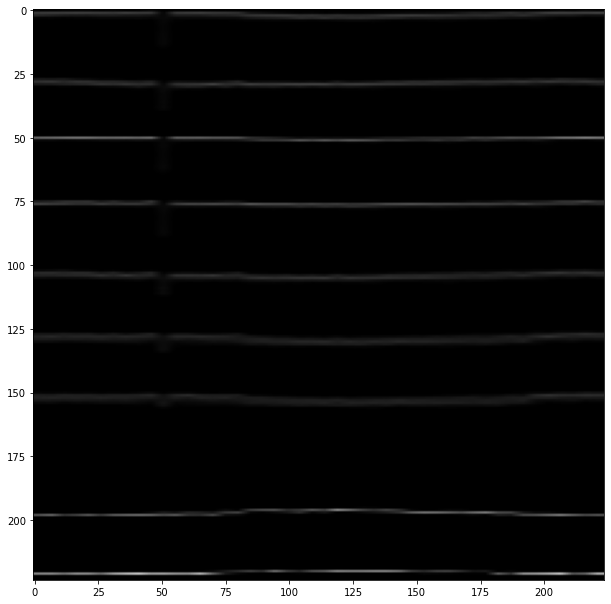

In [8]:
# Plot data for one sample pair
raw_image, crop_yield = crop_dataset_train[0]
figure = plt.figure()
figure.set_size_inches(18.5, 10.5)

print("type of the image: ", type(raw_image))

if type(raw_image) == torch.Tensor:
    plt.imshow(ToPILImage()(raw_image))
else:
    plt.imshow(raw_image)
    
print(f"Yield: {crop_yield}")

In [9]:
# Initialize data loaders
train_dataloader = DataLoader(crop_dataset_train, batch_size=1, shuffle=False)
test_dataloader = DataLoader(crop_dataset_test, batch_size=1, shuffle=False)

In [10]:
# for feature, label in dataloader:
#     print(f"Feature batch shape: {feature.size()}")
#     print(label)
#     print(f"Feature data type: {feature.dtype}")
#     print(f"Label data type: {label.dtype}")

In [11]:
# Check device used
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
# # Basic Neural Network as outlined in lecture notes
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         #self.linear1 = nn.Linear(28*28, 512)
#         #self.linear2 = nn.Linear(512, 512)
#         #self.linear3 = nn.Linear(512, 10)
#         #self.relu = nn.ReLU()
        
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1),
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         #x = self.linear1(x)
#         #x = self.relu(x)
#         #x = self.linear2(x)
#         #x = self.relu(x)
#         #logits = self.linear3(x)
#         logits = self.linear_relu_stack(x)
#         return logits

In [13]:
# Based on https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [14]:
# Based on https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input)
        input = self.fc(input)

        return input

In [15]:
# Potentially use pre-trained model
# resnet_model = models.resnet18(pretrained=True).to(device) 

# Don't use pre-trained
model = ResNet18(in_channels = 3, resblock = ResBlock).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
print(model)

# print(model(crop_dataset[3].to(device)))
# optimizer = torch.optim.Adam

ResNet18(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [65]:
# Train model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    correct, train_loss = 0, 0 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
#         print(f"Actual {y}")
#         print(f"Predicted {pred}")

        # Backpropagation
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step() 
    train_loss /= num_batches
    return train_loss 

In [66]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() 
    
    test_val = pd.DataFrame(columns = ['Actual', 'Predicted', 'Error', 'Error_sq', 'Perc_Err'])
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).item()
            pred = model(X).item()
#             print(f"Actual {y}")
#             print(f"Predicted {pred}")
#             print(f"Error {pred - y}")
#             print(f"Percentage Error {(pred - y) / y}")
                    
            test_val = test_val.append({'Actual' : y, 'Predicted' : pred , 'Error' : abs(pred - y),  'Error_sq': (pred - y)**2, 'Perc_Err' : abs(pred - y) / y}, ignore_index = True)

    return test_val

In [68]:
epochs = 10 # 500
train_loss_history = []
test_history_RMSE = []
test_history_MAPE = []

for t in range(epochs):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_vals = test(test_dataloader, model)
    train_loss_history.append(train_loss)
    test_history_RMSE.append(math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count()))
    test_history_MAPE.append(test_vals['Perc_Err'].mean())
    # test_loss, test_acc = test(testloader, model, loss_fn)
    if t%1 == 0:
        print(f"Epoch {t}:")
        print(f"Avg training loss: {train_loss:>8f}")
        print(f"Root Mean Squared Error: {math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count())}")
        print(f"Mean Average Percentage Error: {test_vals['Perc_Err'].mean()}")
print("Done!")

Epoch 0:
Avg training loss: 2519637.593921
Root Mean Squared Error: 1606.8144392021577
Mean Average Percentage Error: 0.515245842921426
Epoch 1:
Avg training loss: 2460435.618455
Root Mean Squared Error: 1587.8329061013922
Mean Average Percentage Error: 0.507247548953409
Epoch 2:
Avg training loss: 2404475.672389
Root Mean Squared Error: 1570.0777493723888
Mean Average Percentage Error: 0.4996972536669925
Epoch 3:
Avg training loss: 2351980.960007
Root Mean Squared Error: 1554.6651786451414
Mean Average Percentage Error: 0.49270870312657694
Epoch 4:
Avg training loss: 2303169.727695
Root Mean Squared Error: 1538.2078570257258
Mean Average Percentage Error: 0.48690370075793843
Epoch 5:
Avg training loss: 2258407.926581
Root Mean Squared Error: 1520.9854143851046
Mean Average Percentage Error: 0.48174968666883217
Epoch 6:
Avg training loss: 2216050.383843
Root Mean Squared Error: 1505.9772009567544
Mean Average Percentage Error: 0.47437247222706463
Epoch 7:
Avg training loss: 2176633.413

In [18]:
# Save model state
model_path = os.path.join(os.getcwd(), 'model')
print(model_path)

torch.save(model.state_dict(), model_path + '\CNN_model_state.model')

C:\Users\paulr\GitHub\MSBD-5001-Group-Project\PR_Sandbox\model


In [19]:
# Load model state
model_path = os.path.join(os.getcwd(), 'model')
model.load_state_dict(torch.load(model_path + '\CNN_model_state.model'))

<All keys matched successfully>

In [20]:
print(train_loss_history)

[4024096.30859375, 3959054.469512759, 3889632.926572901, 3817977.9237587834, 3743301.272816314, 3666150.0372726168, 3586858.9677474345, 3505958.830705496, 3423944.6009925073, 3341322.205756216]


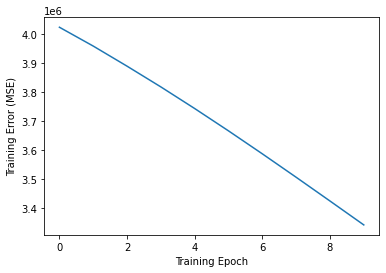

In [21]:
# Plot Training Error
plt.plot(train_loss_history)
plt.ylabel('Training Error (MSE)')
plt.xlabel('Training Epoch')
plt.show()

[Text(0, 0.5, 'Testing Mean Average Percentage Error'),
 Text(0.5, 0, 'Training Epoch')]

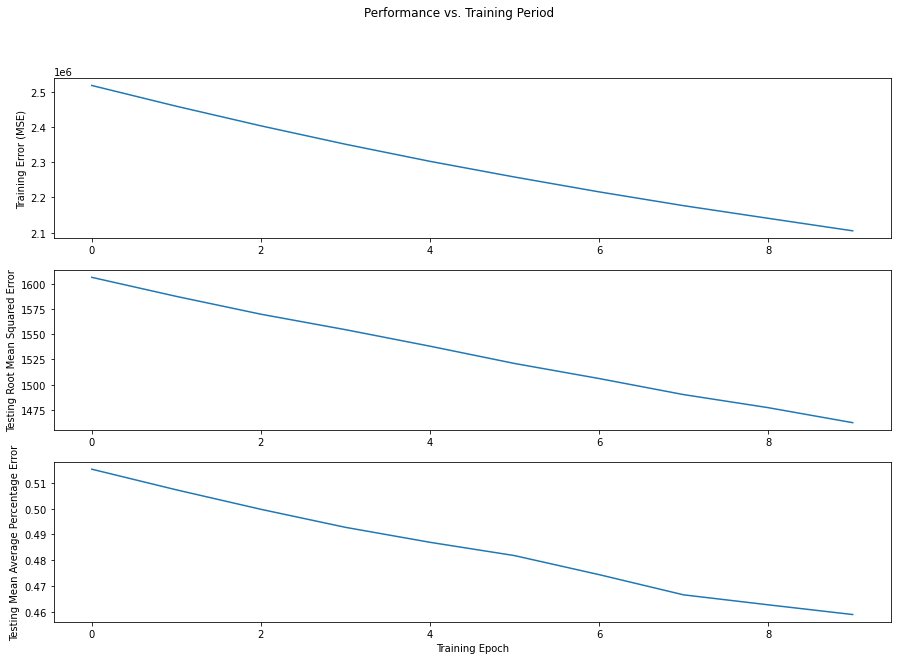

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Performance vs. Training Period')
ax1.plot(train_loss_history)
ax2.plot(test_history_RMSE)
ax3.plot(test_history_MAPE)
ax1.set(ylabel = 'Training Error (MSE)')
ax2.set(ylabel ='Testing Root Mean Squared Error')
ax3.set(ylabel ='Testing Mean Average Percentage Error', xlabel ='Training Epoch')

In [81]:
# Now to make predictions and evaluate model
test_vals = test(test_dataloader, model)
print(f"Root Mean Squared Error: {math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count())}")
print(f"Mean Average Percentage Error: {test_vals['Perc_Err'].mean()}")

Root Mean Squared Error: 1461.9814045069438
Mean Average Percentage Error: 0.4588976517176962


In [82]:
test_vals

,Actual,Predicted,Error,Error_sq,Perc_Err
0,1400.199951,994.765137,405.434814,1.643774e+05,0.289555
1,982.500000,996.354065,13.854065,1.919351e+02,0.014101
2,1336.699951,994.101257,342.598694,1.173739e+05,0.256302
3,940.500000,988.942444,48.442444,2.346670e+03,0.051507
4,1168.900024,998.408325,170.491699,2.906742e+04,0.145857
5,801.900024,961.565735,159.665710,2.549314e+04,0.199109
6,768.700012,453.905487,314.794525,9.909559e+04,0.409515
7,7117.200195,999.748840,6117.451355,3.742321e+07,0.859531
8,1595.400024,453.905487,1141.494537,1.303010e+06,0.715491
9,1830.300049,995.406616,834.893433,6.970470e+05,0.456151
